# Abstract: Efficient Labeling of Unlabeled images 
### **Overall ~87% accuracy was achieved on an unlabeled image corpus (10440) at 5% manual labeling effort**

The balance 13% error images can be corrected 1 by 1 in a targeted manner to take labeling accuracy to 100%. A work flow has been provided to do it correctly and efficiently. 

### **So with 18% (~5 + ~13) effort, an image corpus can be labeled 100% accurately.**

# Efficient Labeling of Unlabeled images
1. Take a large corpus of unlabeled images.
2. Represent each image as a 1001-dimensional vector using ImageNet pre-trained model.
3. Cluster images using PsyFing™, a multi-level clustering algorithm. It brings together the most distinctive images of the corpus and assign the most similar of them respectively to form a number of cluster centers. Then balance images get allocated to the cluster with which it has the highest similarity (novel Bonding Quotient™).
4. A level k cluster center contains $2^k$ images. These images almost always are of the same brand, particularly at the lower level clustering. At higher level, it sometimes gets mixed up with similar looking but different brands in the same cluster center.
5. We will use this property to manually label images in cluster centers at $2^k$ efficiency to build adequate size training data for classification. Number of clusters for 10440 images corpora at levels 1 to 6 were: 2513-594-144-36-6-1. An example of each level shown below:
6. 2513 is too many to label. Level 2 is just right with only 9 out of 594 clusters contain mixed up brands. We get 2340 (~22%) labeled images by looking at only 585 level 2 cluster centers. Randomly chosen 22% for training is low. But here, they have properties of cluster center. This boosts efficiency of classification.

<figure>
<center>
<img src='https://drive.google.com/uc?id=15hLkkG5O3q7YfQgrB7ri9MNbrf88B7CR' />
<figcaption>Level-wise Cluster Centers</figcaption></center>
</figure>

7. Using Nearest Neighbor Classification, achieved test data accuracy of ~84%. So overall accuracy based on this approach was ~87% (84% x 75-80% + 100% x 20-25%).
8. Depending on time available, these specific 13% error images can also be manually labeled leading to 100% accuracy.
9. So, 100% accuracy can be obtained by manually labeling effort of only 18% (5+13) of the corpus.

# More concretely:
1. **Dataset: 13184 product shots detected from grocery store shelf images** [grocerydataset](https://github.com/gulvarol/grocerydataset). Only 2744 labeled images have been used for classifier learning. The balance 10440 unlabelled images from class 0 could not be used. 
2. **Objective: to efficiently label unlabeled data using clustering.** Here clustering will be used to identify the `most similar and distinctive` of images from the dataset and label them manually to build training dataset. 
3. **Feature vector:** Use predictor of [tensorflow_hub classifier](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) and generate 1001-dimensional vector to represent each image
4. **Feature transformation:** Transform raw feature vector thru a series of 5 stages of feature transformation. It is scaled and weighted using properties of specific distribution of data among others
5. **Similarity metric:** Transformation gives a measure of similarity between images (a novel measure, Bonding Quotient)
6. **Clustering:** Ensures most similar groups of images come together as dense cluster centers and less similar gravitate to their respective closest cluster centers. These cluster centers represent the most similar, the most distinctive images from the dataset and also conveniently much fewer in number (PsyFing Clustering algorithm)
7. **Manually label these cluster center images** where size of task is of the order ~1/20 of all unlabeled data
8. Use **new labeled training data** as training and balance images as test data with unknown labels. Nearest neighbors of each test image will be found from new labeled training base
9. Label will be that of the **nearest neighbor**.
10. **Random check** for accuracy and updation of imcorrect label
11. **Efficient manual error correction work flow** provided in the end to improve accuracy of the labeling further.

## 1. Get tensorflow hub classifier

##### Copyright 2018 The TensorFlow Authors.

**Import tf_hub**

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 533.1MB 22kB/s 
     |████████████████████████████████| 460kB 48.7MB/s 
     |████████████████████████████████| 2.9MB 40.8MB/s 
     |████████████████████████████████| 2.8MB 48.8MB/s 
     |████████████████████████████████| 778kB 52.6MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [6]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 102kB 3.0MB/s 


**Get classifier**

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

**Align image shape to imagenet input**

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

## 2. Define a few useful functions

**Import necessary packages for classification**

In [0]:
import numpy as np
import pandas as pd
import PIL.Image as Image
import glob
import scipy.misc
import matplotlib
import cv2
import os
import sys
import multiprocessing
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from tqdm import tnrange, tqdm_notebook, notebook
import time
from datetime import datetime, timedelta
import pytz
from skimage.io import imread_collection
from skimage import io
import imageio
import time, psutil
import pickle
from statistics import mode
import json
import random

Check time left with colab. Useful when working with larger datasets

In [0]:
def colabtime_left():
  Start = time.time()- psutil.boot_time()
  Left= 12*3600 - Start
  print('Time remaining for this session is: ', Left/3600)

In [11]:
colabtime_left()

Time remaining for this session is:  11.547186480032073


Check out RAM usage at this stage. If there are variables not needed henceforth, they can be deleted. We don't want out of memory errors. We are safe in this case as datasize is small.

In [0]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [13]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      Parallel:  1.0 KiB
                           _i3:  662.0 B
                           _i4:  662.0 B
                pack_name_dict:  648.0 B
                           _i9:  581.0 B
                           _i2:  407.0 B
                      datetime:  400.0 B
                     timedelta:  400.0 B
                            _i:  371.0 B
                          _i12:  371.0 B


**Set time zone**

Set it for India where I'm currently located.

In [0]:
tz_cal = pytz.timezone('Asia/Calcutta')

### Useful Function 1: `Image viewer`

In [0]:
def image_viewer(image, truncate, truncate_down=True):
  """
  Input : image to view, truncate to chop off height from top - 1 means no chop
  Output: image view
  """
  if truncate == 0:
    grace_hopper=tf.keras.preprocessing.image.load_img(
        image,
        grayscale=False,
        color_mode='rgb',
        target_size=IMAGE_SHAPE,
        interpolation='nearest')
  else:
    if truncate_down:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          image,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[:int(grace_hopper.shape[0]*truncate),:,:]
      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
    else:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          image,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[int(grace_hopper.shape[0]*truncate):,:,:]
      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest')
  return grace_hopper

### Useful Function 2: `RD maker` given an image using transfer learned class labels as features

In [0]:
def RD_maker_transfer_learned(img, truncate, truncate_down=True):
  if truncate == 0:
    grace_hopper=tf.keras.preprocessing.image.load_img(
        img,
        grayscale=False,
        color_mode='rgb',
        target_size=IMAGE_SHAPE,
        interpolation='nearest'
        )
    grace_hopper = np.array(grace_hopper)
    grace_hopper = np.array(grace_hopper)/255.0
    result = classifier.predict(grace_hopper[np.newaxis, ...])

  else:
    if truncate_down:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          img,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[:int(grace_hopper.shape[0]*truncate),:,:]

      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = np.array(grace_hopper)/255.0
      result = classifier.predict(grace_hopper[np.newaxis, ...])
    else:
      grace_hopper=tf.keras.preprocessing.image.load_img(
          img,
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = grace_hopper[int(grace_hopper.shape[0]*truncate):,:,:]

      matplotlib.image.imsave('name.png', grace_hopper)
      grace_hopper=tf.keras.preprocessing.image.load_img(
          'name.png',
          grayscale=False,
          color_mode='rgb',
          target_size=IMAGE_SHAPE,
          interpolation='nearest'
          )
      grace_hopper = np.array(grace_hopper)
      grace_hopper = np.array(grace_hopper)/255.0
      result = classifier.predict(grace_hopper[np.newaxis, ...])

  return result.reshape(-1,1)

### Useful Function 3: Viewing images forming Cluster Centers

In [0]:
def view_cluster_center(nrows, ncols, image_names, images, fontsize):
  if nrows>1:
    fig, ax = plt.subplots(nrows, ncols, figsize=(20,8))
    for i in range(nrows):
      for j in range(ncols):
        ax[i,j].imshow(io.imread(image_names[i*ncols+j]))
        ax[i,j].axis('off')
        ax[i,j].set_title(images[i*ncols+j], fontsize=fontsize)
  else:
    fig, ax = plt.subplots(ncols, figsize=(20,8))
    for i in range(ncols):
      ax[i].imshow(io.imread(image_names[i]))
      ax[i].axis('off')
      ax[i].set_title(images[i], fontsize=fontsize)
  plt.show()

## 3. Load unlabeled data
You can download the data by uncommenting following cells. I had data data in a google drive. Hence mounted the drive first

In [0]:
# !wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz
# !wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz

In [0]:
# !tar -xvzf GroceryDataset_part1.tar.gz
# !tar -xvzf GroceryDataset_part2.tar.gz

In [0]:
# !bash -c 'mv /content/ProductImagesFromShelves /content/drive/My\ Drive/'

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**`Input Folder Pick up` for images from Drive**

In [20]:
# folders = glob.glob('/content/ProductImagesFromShelves/*')
folders = glob.glob('/content/drive/My Drive/ProductImagesFromShelves/*')
len(folders)

11

In [21]:
folders

['/content/drive/My Drive/ProductImagesFromShelves/3',
 '/content/drive/My Drive/ProductImagesFromShelves/4',
 '/content/drive/My Drive/ProductImagesFromShelves/6',
 '/content/drive/My Drive/ProductImagesFromShelves/1',
 '/content/drive/My Drive/ProductImagesFromShelves/10',
 '/content/drive/My Drive/ProductImagesFromShelves/8',
 '/content/drive/My Drive/ProductImagesFromShelves/2',
 '/content/drive/My Drive/ProductImagesFromShelves/9',
 '/content/drive/My Drive/ProductImagesFromShelves/5',
 '/content/drive/My Drive/ProductImagesFromShelves/7',
 '/content/drive/My Drive/ProductImagesFromShelves/0']

**Getting number of files across folders**

In [23]:
import os, os.path
filecount=0
for folder in folders:
  filecount += len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])
print('Total number of files across all folders: ', filecount)

Total number of files across all folders:  13184


**Create raw data (RD) for this full dataset leading to 1001 features x 13184 packs matrix. Before that let's see how a pack looks**

In [24]:
packs = []
# image_path = '/content/ProductImagesFromShelves/'
image_path = '/content/drive/My Drive/ProductImagesFromShelves/'
for i in range(len(folders)):
  folder_path = str(i)
  filenames = [f for f in os.listdir(f'{image_path}{folder_path}') if f.endswith('png')]
  packs.extend([image_path + folder_path + '/' + filenames[i] for i in range(len(filenames))])

print(' Total number of image files across folders: ', len(packs), '\n',
      'A sample file name:', packs[0])

 Total number of image files across folders:  13184 
 A sample file name: /content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2320_188_200_300.png


**Let's explore the data by viewing random image files out of 13184**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 13184 + 1) instead
  """Entry point for launching an IPython kernel.


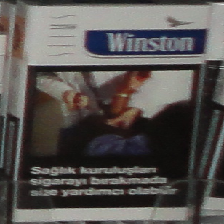

In [25]:
rndm_img_file = np.random.random_integers(0,len(packs),1)
image_viewer(packs[rndm_img_file[0]], truncate=0, truncate_down=False)

**Lower part of many packs changes keeping the branding part the same. Sometimes branding is at the lower part of the pack. So we cannot have one truncate logic for all packs. So we first truncate lower part of all packs and cluster and then we can come back to truncate upper part and cluster again**

In [0]:
truncate = 0.4

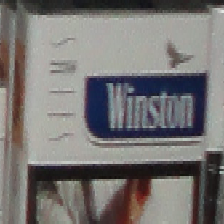

In [27]:
image_viewer(packs[rndm_img_file[0]], truncate=truncate, truncate_down=True)

## 4. Compute feature matrix of all images (raw data - RD)
This will give the distribution of the corpus in terms of 1001-dimensional vectors leading to suitable scaling and weights to apply for this corpus to compute the similarity measure, Bonding Quotient.

In [0]:
%%time
t0 = time.time()
RD = np.zeros((1001,len(packs)))       # Preallocate space for the large arra
for i in range(len(packs)):
  RD[:,[i]] = RD_maker_transfer_learned(packs[i], truncate, truncate_down=True)
  if ((i%100 == 0) & (i>0)):
    t = time.time()
    so_far = t-t0
    avg = so_far/i
    exp = avg * (len(packs)-i)/60
    now = datetime.now(tz_cal)
    future = now + timedelta(minutes = exp)
    future_time = future.strftime("%H:%M:%S")
    print(f'Done {i} images in {so_far:.1f} s. Expect to finish at {future_time}.')

RD = RD/RD.max()

**Getting the class intervals for RD**

This is to convert raw numbers into a 5-point scale. The class intervals depend on the data distribution and is specific for this RD of the overall dataset.

In [0]:
class_int = [-0.0790130310188110, -0.0311130310188163, 0.0110869689811790, 0.0652869689811730, 1.0000000000000000]  #  40%

**We found folder '0' contains mixed up packs as can be seen below. The rest of the folders named below.**

In [0]:
pack_name_dict = {0: 'Undefined',
                  1: 'Marlboro',
                  2: 'Kent',
                  3: 'Camel',
                  4: 'Parliament',
                  5: 'Pall Mall',
                  6: 'Monte Carlo',
                  7: 'Winston',
                  8: 'Lucky Strike',
                  9: '2001',
                  10: 'Lark'}

**Function to see contents of different folders**


In [0]:
def folder_viewer(i):
  """
  Input:  i is folder number from 0 to 10
  Output: view of 32 randomly chosen packs from the chosen folder
  """
  # image_path = '/content/ProductImagesFromShelves/'
  image_path = '/content/drive/My Drive/ProductImagesFromShelves/'
  folder_path = str(i)
  folder_files = [f for f in os.listdir(f'{image_path}{folder_path}') if f.endswith('png')]
  folder_path = str(i)
  shownum = 32;
  rndm_img_index_i = random.sample(range(len(folder_files)), shownum)
  rndm_img_files_i = [image_path + folder_path + '/' + folder_files[rndm_img_index_i[i]] for i in range(shownum)]
  rndm_img_names_i = [pack_name_dict[int(rndm_img_files_i[i].split('/')[-2])] for i in range(shownum)]
  view_cluster_center(4, 8, rndm_img_files_i, rndm_img_names_i, 10)

Let's see folder 0 to see the spread of different packs

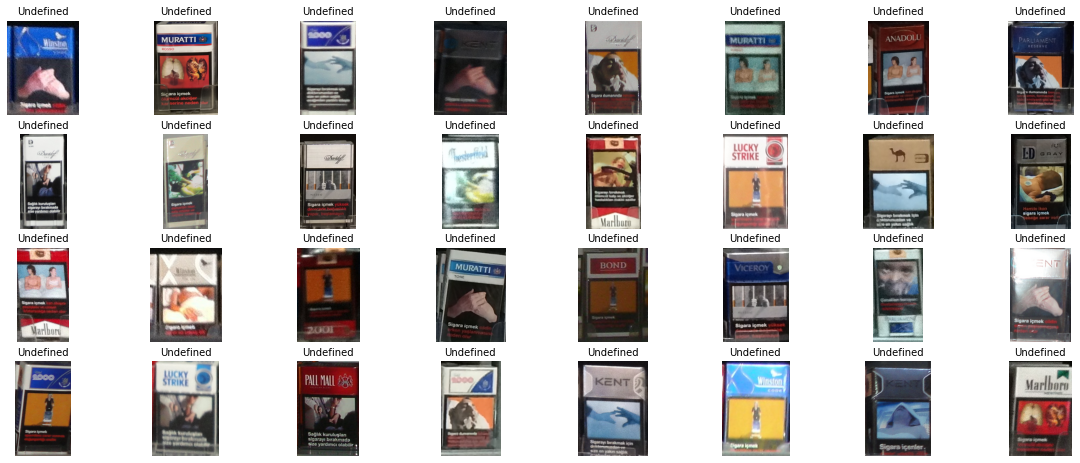

In [34]:
folder_viewer(0)

**Folder 0 is unlabeled and RD_train will be created out of it to build clusters of similar looking packs to help label them efficiently**

## 5. Compute RD_train from unlabeled data

**First create a list of filenames in folder 0**

In [0]:
# train_ImageFileList = glob.glob('/content/ProductImagesFromShelves/' + str(0) + '/*.png')
train_ImageFileList = glob.glob('/content/drive/My Drive/ProductImagesFromShelves/' + str(0) + '/*.png')

In [0]:
%%time
t0 = time.time()
RD_train = np.zeros((1001,len(train_ImageFileList)))       # Initializer for 1001 x N training data RD
for i in range(len(train_ImageFileList)):
  RD_train[:,[i]] = RD_maker_transfer_learned(train_ImageFileList[i], truncate, truncate_down=True)
  if ((i%100 == 0) & (i>0)):
    t = time.time()
    so_far = t-t0
    avg = so_far/i
    exp = avg * (len(train_ImageFileList)-i)/60
    now = datetime.now(tz_cal)
    future = now + timedelta(minutes = exp)
    future_time = future.strftime("%H:%M:%S")
    print(f'Done {i} images in {so_far:.1f} s. Expect to finish at {future_time}.')

Done 100 images in 37.0 s. Expect to finish at 14:21:37.
Done 200 images in 71.5 s. Expect to finish at 14:19:24.
Done 300 images in 107.1 s. Expect to finish at 14:19:19.
Done 400 images in 141.5 s. Expect to finish at 14:18:46.
Done 500 images in 183.3 s. Expect to finish at 14:21:00.
Done 600 images in 217.7 s. Expect to finish at 14:20:21.
Done 700 images in 252.1 s. Expect to finish at 14:19:52.
Done 800 images in 284.7 s. Expect to finish at 14:19:08.
Done 900 images in 316.3 s. Expect to finish at 14:18:22.
Done 1000 images in 348.2 s. Expect to finish at 14:17:48.
Done 1100 images in 380.2 s. Expect to finish at 14:17:21.
Done 1200 images in 411.8 s. Expect to finish at 14:16:55.
Done 1300 images in 444.8 s. Expect to finish at 14:16:45.
Done 1400 images in 480.4 s. Expect to finish at 14:16:55.
Done 1500 images in 518.4 s. Expect to finish at 14:17:20.
Done 1600 images in 565.3 s. Expect to finish at 14:18:41.
Done 1700 images in 610.0 s. Expect to finish at 14:19:39.
Done 180

In [0]:
RD_train.shape, RD_train.max()

((1001, 10440), 14.273734092712402)

In [0]:
print(' Shape of training raw data file: ', RD_train.shape, '\n',
      'Max value in RD_train: ', RD_train.max(), '\n',
      'Min value in RD_train: ', RD_train.min())

 Shape of training raw data file:  (1001, 10440) 
 Max value in RD_train:  14.273734092712402 
 Min value in RD_train:  -7.533865928649902


**It's a good idea to save RD_train file as csv and retrieve later as and when needed**

In [0]:
np.savetxt("/content/drive/My Drive/t/RD_train_folder_0_40pc.csv", RD_train, delimiter=",")

In [0]:
RD_train = np.genfromtxt('/content/drive/My Drive/t/RD_train_folder_0_40pc.csv', delimiter=',')

**Normalize RD_train to make it comparable across datasets**

In [0]:
RD_train_max=RD_train.max()
RD_train_min=RD_train.min()
RD_train = RD_train/RD_train_max

In [38]:
print(' Shape of training raw data file: ', RD_train.shape, '\n',
      'Max value in RD_train: ', RD_train_max, '\n',
      'Min value in RD_train: ', RD_train_min)

 Shape of training raw data file:  (1001, 10440) 
 Max value in RD_train:  14.273734092712402 
 Min value in RD_train:  -7.533865928649902


**Convert raw numbers in RD_train to a 5-point scale using class intervals obtained earlier**

In [0]:
RD_train[RD_train < class_int[0]] = 1
RD_train[RD_train < class_int[1]] = 2
RD_train[RD_train < class_int[2]] = 3
RD_train[RD_train < class_int[3]] = 5
RD_train[RD_train < class_int[4]] = 7

## 6. Compute similarity matrices of training images
First the weights to be used given the distribution of the raw data

In [0]:
wt = [1.00,0.547727132220402,0.300005011370386,0.164320884529651,0.0900030068473456]  # 40%

**We will do a parallelized implementation of BQRS to make full use of colab TPU giving 40 workers. For that we will define BQRS function for input on 5-point scale**

In [0]:
def out_bqrs(RD_train, i, wt):
    
    a = np.multiply(RD_train[:,i].reshape([1001,-1]),RD_train[:,i:])
        
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]
    
    a = a.sum(axis=0)
    
    return a

In [42]:
num_cores = multiprocessing.cpu_count()
num_cores

40

In [43]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(out_bqrs)(RD_train, i, wt) for i in notebook.tqdm(range(RD_train.shape[1])))


CPU times: user 1min 17s, sys: 4.78 s, total: 1min 22s
Wall time: 3min


In [44]:
%%time
BQRS = np.zeros((RD_train.shape[1], RD_train.shape[1]))
for i in range(RD_train.shape[1]):
    BQRS[(RD_train.shape[1] - len(results[i])),(RD_train.shape[1] - len(results[i])):] = results[i]
    BQRS[(RD_train.shape[1] - len(results[i])):,(RD_train.shape[1] - len(results[i]))] = results[i]

CPU times: user 1.08 s, sys: 373 ms, total: 1.45 s
Wall time: 1.45 s


In [45]:
BQRS.shape

(10440, 10440)

**It's a good idea to save BQRS file as csv and retrieve later as and when needed.**

*But don't have space at google drive at the moment*

In [0]:
# np.savetxt("/content/drive/My Drive/t/BQRS_train_folder_0.csv", BQRS, delimiter=",")

In [0]:
# BQRS = np.genfromtxt('/content/drive/My Drive/t/BQRS_train_folder_0.csv', delimiter=',')

**Check out size of variables stored at this stage.**

In [46]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          BQRS: 831.6 MiB
                      RD_train: 79.7 MiB
                         packs: 103.9 KiB
           train_ImageFileList: 91.4 KiB
                  folder_files: 85.6 KiB
                       results: 85.6 KiB
                          _i16:  2.0 KiB
                      Parallel:  2.0 KiB
                          _i15:  1.6 KiB
                          _i31:  820.0 B


**More transformation to get BQ**

In [47]:
%%time
BQRS = BQRS/np.diagonal(BQRS)                          # Bonding Quotient Normalized Score
BQCorr1 = np.corrcoef(BQRS.T)                          # Bonding Quotient Correlation Level 1

CPU times: user 1min 15s, sys: 20.9 s, total: 1min 36s
Wall time: 5.94 s


## 7. Compute Cluster Centers at different hierarchy

### Level 1 clustering
Note: `Top 40% has been taken as representation of a pack` as most have non-branded warning in the lower part for the same brand which would interfere with correct pack recognition

In [48]:
%%time
mmp_1 = []
for i in range(BQCorr1.shape[0]):
  start_image = train_ImageFileList[i]
  max_img = np.array(train_ImageFileList)[BQCorr1[i].argsort()[-2:][0]]
  max_max_img = np.array(train_ImageFileList)[BQCorr1[train_ImageFileList.index(max_img)].argsort()[-2:][0]]
  if ((start_image == max_max_img) & (i < train_ImageFileList.index(max_img))):
    img1 = start_image
    img2 = max_img
    mmp_1.append([img1, img2, i, train_ImageFileList.index(max_img)])

CPU times: user 57.2 s, sys: 54.3 s, total: 1min 51s
Wall time: 1min 51s


### Ideally we would like each clusters to comprise images of one brand only and hence number of clusters equal to number of unique brands. But because of image quality and varying non-branding elements, there will be more than 1 cluster for each brand to reflect this variation.

**First Pickle mmp1-s and send to google drive for later re-use**

In [0]:
with open('/content/drive/My Drive/t/mmp1_40pc.csv', 'wb') as fp:
  pickle.dump(mmp_1, fp)

**Unpickle mmp1 from google drive and bring back**

In [0]:
with open('/content/drive/My Drive/t/mmp1_40pc.csv', "rb") as fp:
  mmp_1 = pickle.load(fp)

Get **number of Level 1 clusters** where 2 most similar and distinctive images from the training base form a cluster center

In [49]:
N_L1 = len(mmp_1)
print('Number of Level 1 clusters: ', N_L1)

Number of Level 1 clusters:  2513


**See Structure and view a random selection of Level 1 Cluster Center**

Structure of Level 1 Cluster Center no:  375 
 Image 1 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C4_P02_N4_S3_1.JPG_344_1464_160_224.png 
 Image 2 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C4_P02_N4_S3_1.JPG_488_1460_160_224.png 
 train_ImageFileList Index of Image 1 of cluster center:  1369 
 train_ImageFileList Index of Image 2 of cluster center:  1390


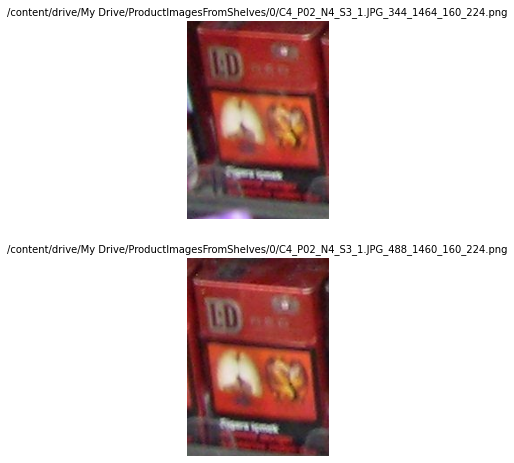

In [50]:
i=random.sample(range(N_L1),1)[0]
x=[mmp_1[i][0],mmp_1[i][1]]
print('Structure of Level 1 Cluster Center no: ', i, '\n',
      'Image 1 of cluster center: ', x[0], '\n',
      'Image 2 of cluster center: ', x[1], '\n',
      'train_ImageFileList Index of Image 1 of cluster center: ', mmp_1[i][2], '\n',
      'train_ImageFileList Index of Image 2 of cluster center: ', mmp_1[i][3])
view_cluster_center(1, 2, x, x, 10)

#2510 out of 2513 level 1 cluster centers contain 2 packs of same brand. Thus for the effort of labeling 2510, it is possible to label 5000+ images out of 10440. But that's too many. Let's see if it can be reduced further with Level 2 clustering.

**To do that allocate all unlabeled images to that L1 clusters with which it has the highest Bonding Quotient**

In [0]:
L1_BLOAD = np.zeros((BQRS.shape[0], N_L1))
L1_CLOAD = np.zeros((BQCorr1.shape[0], N_L1))
for i in range(N_L1):
    L1_BLOAD[:,i] = (BQRS[:,mmp_1[i][2]] + BQRS[:,mmp_1[i][3]])
    L1_CLOAD[:,i] = (BQCorr1[mmp_1[i][2],:] + BQCorr1[mmp_1[i][3],:])

In [0]:
Top_100 = [L1_CLOAD[i].argsort()[-101:][::-1][1:] for i in range(BQCorr1.shape[0])]
L1_Allocation_1 = [L1_CLOAD[i].argsort()[-5:][::-1][0] for i in range(BQCorr1.shape[0])]

#### Level 2 clustering
Level 2 clustering combines the 2 most similar and distinctive Level 1 clusters together to form level 2 clusters

In [0]:
L2Corr1 = np.corrcoef(L1_BLOAD.T)                          # Bonding Quotient Correlation Level 1

In [54]:
%%time
mmp_2 = []
for i in range(N_L1):
    start_mmp_index = np.array(i)
    max_mmp_index = L2Corr1[i].argsort()[-2:][::-1][1:]
    max_max_mmp_index = L2Corr1[max_mmp_index][0,:].argsort()[-2:][::-1][1:]
    if ((i == max_max_mmp_index) & (i < max_mmp_index)):
        mmp_2.append([mmp_1[i], mmp_1[max_mmp_index[0]]])

CPU times: user 903 ms, sys: 0 ns, total: 903 ms
Wall time: 903 ms


**First pickle mmp2-s and send to google drive for later re-use**

In [0]:
with open('/content/drive/My Drive/t/mmp2_40pc.csv', 'wb') as fp:
  pickle.dump(mmp_2, fp)

**Unpickle mmp2 from google drive and bring back**

In [0]:
with open('/content/drive/My Drive/t/mmp2_40pc.csv', "rb") as fp:
  mmp_2 = pickle.load(fp)

Get **number of Level 2 clusters** where there are 4 most similar and distinctive images form the cluster center

In [57]:
N_L2 = len(mmp_2)
print('Number of Level 2 clusters: ', N_L2)

Number of Level 2 clusters:  594


**See Structure and view a random selection of Level 2 Cluster Center**

Structure of Level 2 Cluster Center no:  176 
 Image 1 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C3_P06_N1_S5_1.JPG_2688_2040_188_312.png 
 Image 2 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C3_P06_N3_S4_2.JPG_2956_1424_216_364.png 
 Image 3 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C3_P06_N3_S3_1.JPG_3344_1712_276_452.png 
 Image 4 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C3_P06_N4_S3_1.JPG_3612_1136_284_476.png 
 train_ImageFileList Index of Image 1 of cluster center:  2433 
 train_ImageFileList Index of Image 2 of cluster center:  2681 
 train_ImageFileList Index of Image 3 of cluster center:  2577 
 train_ImageFileList Index of Image 4 of cluster center:  2731


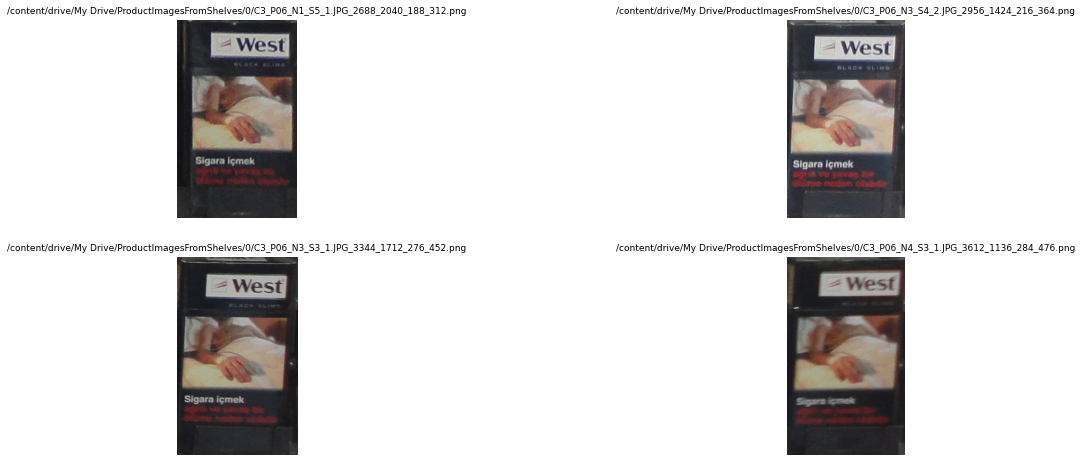

In [58]:
i=random.sample(range(N_L2),1)[0]
x=[mmp_2[i][0][0],mmp_2[i][0][1],mmp_2[i][1][0],mmp_2[i][1][1]]
print('Structure of Level 2 Cluster Center no: ', i, '\n',
      'Image 1 of cluster center: ', x[0], '\n',
      'Image 2 of cluster center: ', x[1], '\n',
      'Image 3 of cluster center: ', x[2], '\n',
      'Image 4 of cluster center: ', x[3], '\n',
      'train_ImageFileList Index of Image 1 of cluster center: ', mmp_2[i][0][2], '\n',
      'train_ImageFileList Index of Image 2 of cluster center: ', mmp_2[i][0][3], '\n',
      'train_ImageFileList Index of Image 3 of cluster center: ', mmp_2[i][1][2], '\n',
      'train_ImageFileList Index of Image 4 of cluster center: ', mmp_2[i][1][3])
view_cluster_center(2, 2, x, x, 9)

## Each mmp_2 contain packs of same brand (barring a few exceptions as we will see). Thus labeling about 594 plates will give 2400-odd labeled images out of 10440 unlabeled images i.e. 5-6% effort, 20-25% result. We will use these labeded images as training data for classifying the balance ~8000 images.

**First, initialize an empty dictionary to contain pack labels and for images in manually identified 594 cluster centers**

In [0]:
# label_dict = {}

**Bring back saved json.dump of pack label dict where we have already labeled Level 2 cluster centers**

In [0]:
label_dict = json.load( open( '/content/drive/My Drive/t/label.json' ) )

In [60]:
print(f'There are {len([item for sublist in label_dict.values() for item in sublist])} manually labeled 4 identical packs from each Level 2 cluster centers across {len(label_dict)} brands')

There are 2340 manually labeled 4 identical packs from each Level 2 cluster centers across 30 brands


**View a randomly selected pack for each of the 30 labeled Brands as an Index page**

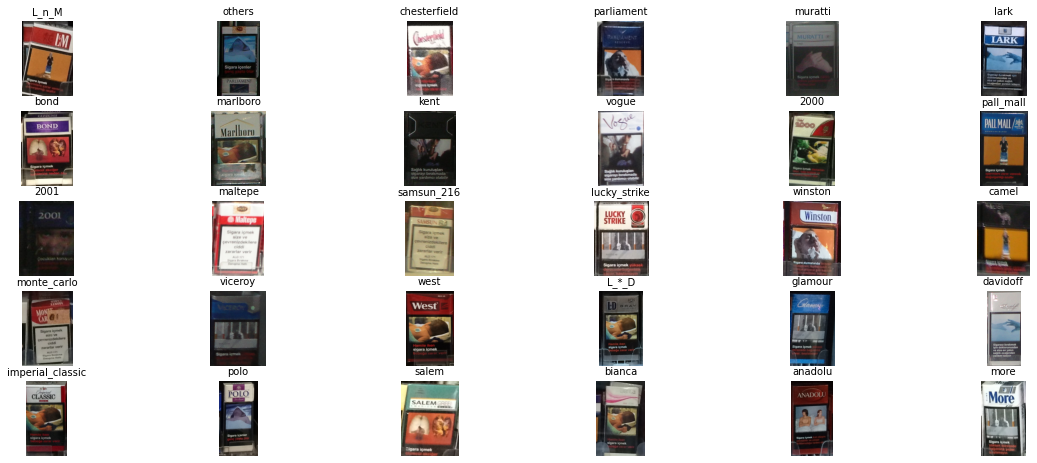

In [61]:
brand_list=list(label_dict.keys())
brand_file_list=[label_dict[brand_list[i]][random.sample(range(len(label_dict[brand_list[i]])), 1)[0]] for i in range(len(brand_list))]
view_cluster_center(5,6, brand_file_list, brand_list, 10)

**Packs with branding at the bottom part has been labeled as others since only top 40% has been used for this clustering**

## Now starting manual labeling packs at 594 Cluster Centers i.e. mmp_2 from 0 to 593

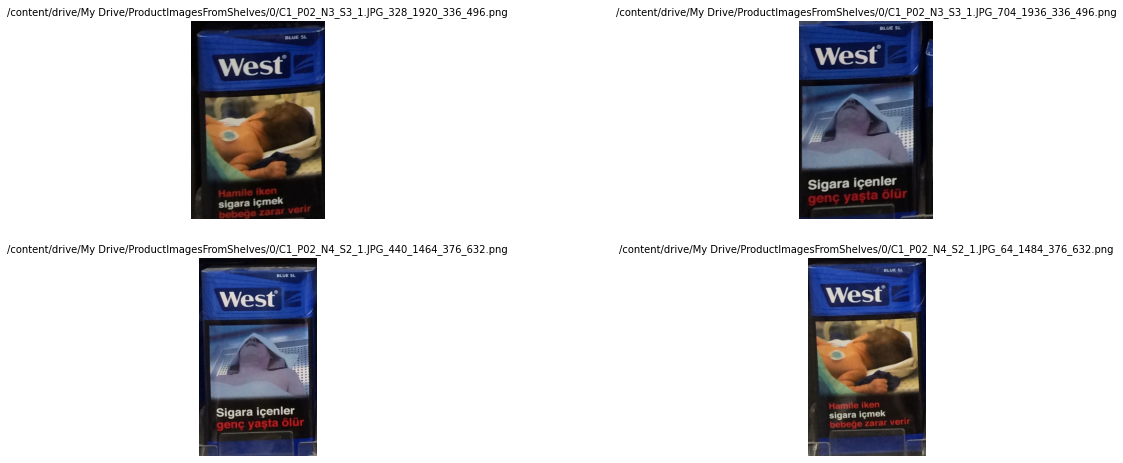

In [62]:
i=593
x=[mmp_2[i][0][0],mmp_2[i][0][1],mmp_2[i][1][0],mmp_2[i][1][1]]
view_cluster_center(2, 2, x, x, 10)

**Extend values for existing brand key and save to json file at google drive**

In [0]:
# label_dict['west'].extend(x)
# json.dump( label_dict, open( "/content/drive/My Drive/t/label.json", 'w' ) )
# print(f'Identified {len([item for sublist in label_dict.values() for item in sublist])} images for {len(label_dict)} brand/variants')

Identified 2340 images for 30 brand/variants


**Add new brand key to dict and save to json file at google drive. It shows the last added brand 'More'**

In [0]:
# label_dict['more'] = x
# json.dump( label_dict, open( "/content/drive/My Drive/t/label.json", 'w' ) )
# print(f'Identified {len([item for sublist in label_dict.values() for item in sublist])} images for {len(label_dict)} brand/variants')

Identified 2100 images for 30 brand/variants


In [63]:
colabtime_left()

Time remaining for this session is:  10.982639278305902


# One more thing. If human eye can recognize, poor quality of image does not matter as long as there are enough poor quality images to match with. In fact less bad of them help identify the real bad ones.

### The benefit of this cluster center labeling approach will be evident from the following interesting examples:

In [0]:
int_ex = [7,33,69,90,93,104,114,127,133,138,204,205,207,208,228,276,277,280,281,286,305,318,330,340,356,416,491,545,549]

**Showing one randomly chosen interesting Level 2 Cluster Center example. Repeatedly run the cell to see other interesting examples**

Interesting cluster number: 208


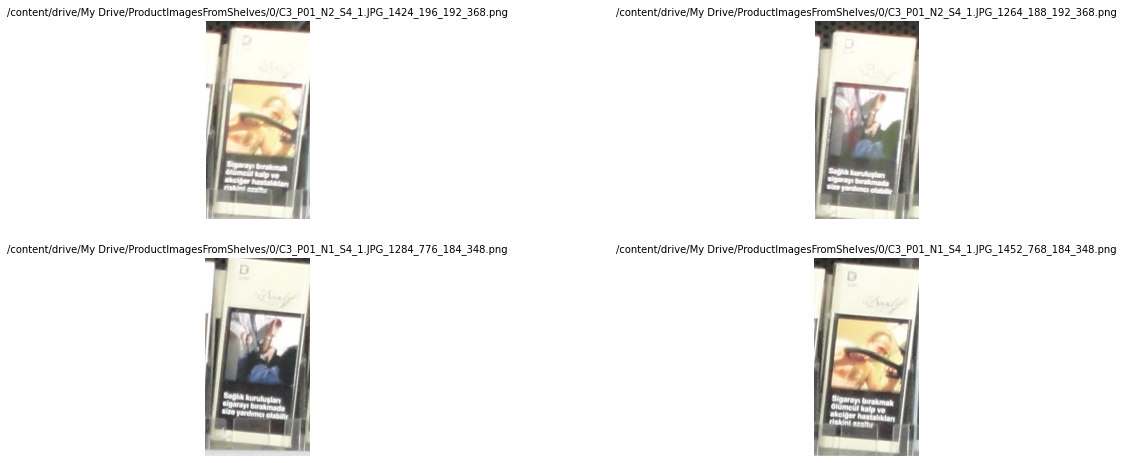

In [75]:
i=int_ex[random.sample(range(len(int_ex)),1)[0]]
x=[mmp_2[i][0][0],mmp_2[i][0][1],mmp_2[i][1][0],mmp_2[i][1][1]]
print('Interesting cluster number:', i)
view_cluster_center(2, 2, x, x, 10)

## Summary of interesting cluster center images
**Hazy images:**

7,90,104,138,277,280,281,286

**Difficult to read but made easy due to others in cluster that are easier to read:**

33,69,93,127,133,204,205,207,208,228,276,305,318,330,340,356,416,545,549

**Correct clustering despite reduced data area:**

491

**9 cluster centers out of 594 had brands mixed up (<2%):**

In [0]:
mix_up = [102, 135, 225, 268, 273, 288, 292, 381, 466]

The reason for mix up in most cases is the image quality as evident below:

Mixed-up cluster number: 135


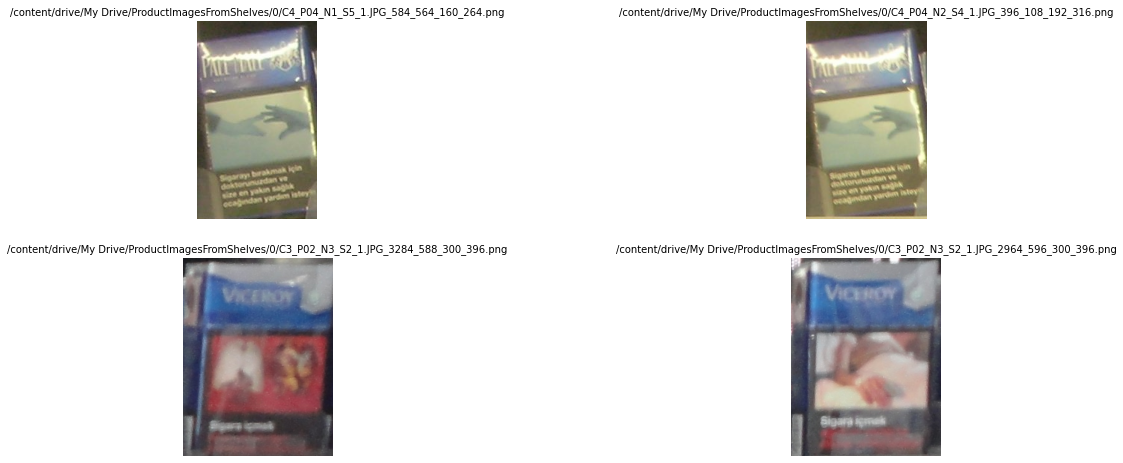

In [87]:
i=mix_up[random.sample(range(len(mix_up)),1)[0]]
x=[mmp_2[i][0][0],mmp_2[i][0][1],mmp_2[i][1][0],mmp_2[i][1][1]]
print('Mixed-up cluster number:', i)
view_cluster_center(2, 2, x, x, 10)

# Hence we have (594-9)*4=2340 labeled images for training i.e. about ~22% for training 78% for testing.

**Train-test break is normally the other way round. But that would have taken a very large time and cost investment.**

## **We are aiming for ~85-90% accuracy on unlabeled corpus at the cost of only 5% manual labeling.**

### Let's do the Level 3 clustering to see where it goes.
**For that we have to allocate all 10440 images to L2 clusters**

In [0]:
L2_BLOAD = np.zeros((BQRS.shape[0], N_L2))
L2_CLOAD = np.zeros((BQCorr1.shape[0], N_L2))
for i in range(N_L2):
    L2_BLOAD[:,i] = (BQRS[:,mmp_2[i][0][2]] + BQRS[:,mmp_2[i][0][3]] + 
                     BQRS[:,mmp_2[i][1][2]] + BQRS[:,mmp_2[i][1][3]])
    L2_CLOAD[:,i] = (BQCorr1[mmp_2[i][0][2],:] + BQCorr1[mmp_2[i][0][3],:] + 
                     BQCorr1[mmp_2[i][1][2],:] + BQCorr1[mmp_2[i][1][3],:])

In [0]:
L2_Allocation_1 = [L2_CLOAD[i].argsort()[-5:][::-1][0] for i in range(BQCorr1.shape[0])]

#### Level 3 clustering
Level 3 clustering combines the 2 most similar and distinctive Level 2 clusters together to form level 3 clusters

In [0]:
L3Corr1 = np.corrcoef(L2_BLOAD.T)                          # Bonding Quotient Correlation Level 1

In [91]:
%%time
mmp_3 = []
for i in range(N_L2):
    start_mmp_index = np.array(i)
    max_mmp_index = L3Corr1[i].argsort()[-2:][::-1][1:]
    max_max_mmp_index = L3Corr1[max_mmp_index][0,:].argsort()[-2:][::-1][1:]
    if ((i == max_max_mmp_index) & (i < max_mmp_index)):
        mmp_3.append([mmp_2[i], mmp_2[max_mmp_index[0]]])

CPU times: user 45.2 ms, sys: 563 µs, total: 45.7 ms
Wall time: 45.3 ms


**First pickle mmp3-s and send to google drive for later re-use**

In [0]:
with open('/content/drive/My Drive/t/mmp3_40pc.csv', 'wb') as fp:
  pickle.dump(mmp_3, fp)

**Unpickle mmp3 from google drive and bring back**

In [0]:
with open('/content/drive/My Drive/t/mmp3_40pc.csv', "rb") as fp:
  mmp_3 = pickle.load(fp)

Get **number of Level 3 clusters** where there are 8 most similar and distinctive images form the cluster center

In [94]:
N_L3 = len(mmp_3)
print('Number of Level 3 clusters: ', N_L3)

Number of Level 3 clusters:  144


**Structure of a Level 3 Cluster Center**

Structure of Level 3 Cluster Center no:  77 
 Image 1 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P07_N1_S6_2.JPG_216_844_104_152.png 
 Image 2 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P09_N1_S7_2.JPG_256_860_104_164.png 
 Image 3 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P07_N1_S6_2.JPG_320_852_104_152.png 
 Image 4 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P09_N1_S7_2.JPG_352_864_104_164.png 
 Image 5 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P08_N3_S3_1.JPG_316_836_220_380.png 
 Image 6 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P08_N3_S3_1.JPG_112_840_220_380.png 
 Image 7 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P09_N1_S7_2.JPG_1248_888_96_136.png 
 Image 8 of cluster center:  /content/drive/My Drive/ProductImagesFromShelves/0/C2_P09_N1_S7_2.JPG_1332_892_96_136.

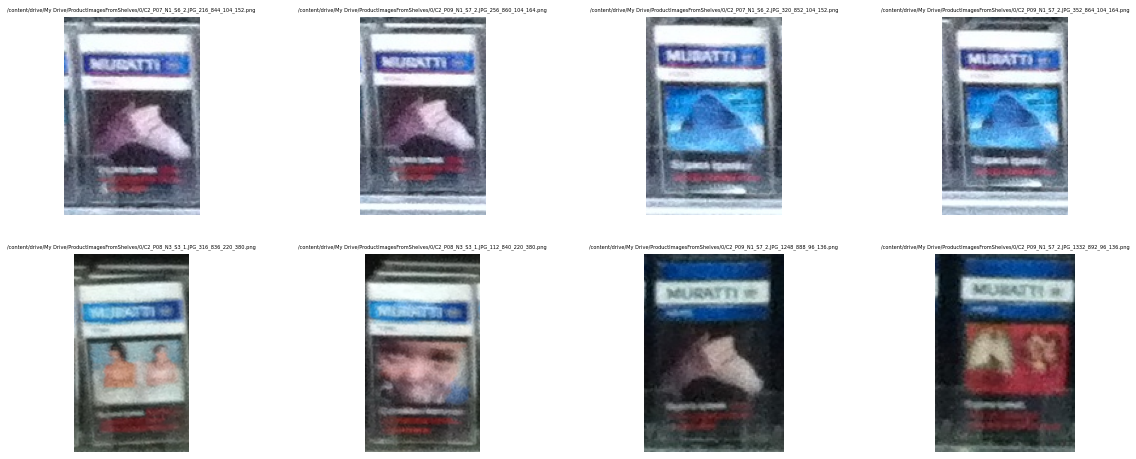

In [104]:
i=random.sample(range(N_L3),1)[0]
x=[mmp_3[i][0][0][0],mmp_3[i][0][0][1],mmp_3[i][0][1][0],mmp_3[i][0][1][1],mmp_3[i][1][0][0],mmp_3[i][1][0][1],mmp_3[i][1][1][0],mmp_3[i][1][1][1]]
print('Structure of Level 3 Cluster Center no: ', i, '\n',
      'Image 1 of cluster center: ', x[0], '\n',
      'Image 2 of cluster center: ', x[1], '\n',
      'Image 3 of cluster center: ', x[2], '\n',
      'Image 4 of cluster center: ', x[3], '\n',
      'Image 5 of cluster center: ', x[4], '\n',
      'Image 6 of cluster center: ', x[5], '\n',
      'Image 7 of cluster center: ', x[6], '\n',
      'Image 8 of cluster center: ', x[7], '\n',
      'train_ImageFileList Index of Image 1 of cluster center: ', mmp_3[i][0][0][2], '\n',
      'train_ImageFileList Index of Image 2 of cluster center: ', mmp_3[i][0][0][3], '\n',
      'train_ImageFileList Index of Image 3 of cluster center: ', mmp_3[i][0][1][2], '\n',
      'train_ImageFileList Index of Image 4 of cluster center: ', mmp_3[i][0][1][3], '\n',
      'train_ImageFileList Index of Image 5 of cluster center: ', mmp_3[i][1][0][2], '\n',
      'train_ImageFileList Index of Image 6 of cluster center: ', mmp_3[i][1][0][3], '\n',
      'train_ImageFileList Index of Image 7 of cluster center: ', mmp_3[i][1][1][2], '\n',
      'train_ImageFileList Index of Image 8 of cluster center: ', mmp_3[i][1][1][3])
view_cluster_center(2, 4, x, x, 5)

## As you can see many of 144 Level 3 cluster centers contain packs of same brand. Thus scope for further efficiency in overall classification effort i.e. labeling 144 plates will give about 1100 (144*8) labeled images out of 10440 unlabeled images i.e. 1.5% effort, 11% labeling and classifying balance 90%, but there are 2 problems:
1. training data at 11% is too small to learn nuances for 89% of unlabeled packs.
2. further, higher % of Level 3 cluster centers would contain mixed-up brand packs than Level 2 hence training data size will be even smaller than 11% 

**Hence we will retain manual labeling at Level 2 and see what accuracy we get.**

# Build New RD to find nearest neighbor of 2340 images labeled manually above
Find their
  - index from the total 10440 images in train_ImageFileList
  - filepath
  - label


In [0]:
unlabel_index_brand_tuple = [[i,brand] for i,j in enumerate(train_ImageFileList) for brand in brand_list for k in range(len(label_dict[brand])) if label_dict[brand][k] == j]

In [0]:
train_image_index = [unlabel_index_brand_tuple[i][0] for i in range(len(unlabel_index_brand_tuple))]
train_labeled_files_flat = [train_ImageFileList[unlabel_index_brand_tuple[i][0]] for i in range(len(unlabel_index_brand_tuple))]
train_image_label = [unlabel_index_brand_tuple[i][1] for i in range(len(unlabel_index_brand_tuple))]

**Check a few randomly to test of brand and image match in training dataset**

Brand:  west , index number 736


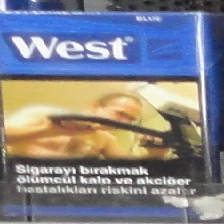

In [107]:
i=random.sample(range(len(unlabel_index_brand_tuple)),1)[0]
print('Brand: ', train_image_label[i], ', index number', i)
image_viewer(train_ImageFileList[train_image_index[i]],truncate=0,truncate_down=False)

**Cull out from RD_train of all 10440 unlabeled images the labeled ones using index above**

In [0]:
RD_nn = RD_train[:,train_image_index]

**It's a good idea to save RD_nn file as csv and retrieve later as and when needed**

In [0]:
np.savetxt("/content/drive/My Drive/t/RD_nn_folder_0_40pc.csv", RD_nn, delimiter=",")

In [0]:
RD_nn = np.genfromtxt('/content/drive/My Drive/t/RD_nn_folder_0_40pc.csv', delimiter=',')

**We will do a parallelized implementation of BQRS to make full use of colab TPU giving 40 workers. For that we will define BQRS function for input on 5-point scale**

In [110]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(out_bqrs)(RD_nn, i, wt) for i in notebook.tqdm(range(RD_nn.shape[1])))


CPU times: user 12.4 s, sys: 1.99 s, total: 14.4 s
Wall time: 16.5 s


In [111]:
%%time
BQRS = np.zeros((RD_nn.shape[1], RD_nn.shape[1]))
for i in range(RD_nn.shape[1]):
    BQRS[(RD_nn.shape[1] - len(results[i])),(RD_nn.shape[1] - len(results[i])):] = results[i]
    BQRS[(RD_nn.shape[1] - len(results[i])):,(RD_nn.shape[1] - len(results[i]))] = results[i]

CPU times: user 40.8 ms, sys: 20 ms, total: 60.8 ms
Wall time: 59.9 ms


In [112]:
BQRS.shape

(2340, 2340)

## Now we create 2 types of class predictor function

**Class Predictor Function_c**

Class Predictor Function Type C

In [0]:
def nn_finder_c(i,k):
  # input_image = train_ImageFileList[rndm_img_file[0]]
  input_image = train_ImageFileList[i]
  test_feature = RD_maker_transfer_learned(input_image, truncate, truncate_down=True)
  test_feature = test_feature/RD_train_max
  
  test_feature[test_feature < class_int[0]] = 1
  test_feature[test_feature < class_int[1]] = 2
  test_feature[test_feature < class_int[2]] = 3
  test_feature[test_feature < class_int[3]] = 5
  test_feature[test_feature < class_int[4]] = 7

  RD_TEST = np.concatenate((RD_nn, test_feature), axis=1)
  BQRS_test = np.zeros((RD_nn.shape[1]+1, RD_nn.shape[1]+1))

  a = np.multiply(RD_TEST[:,-1].reshape([1001,-1]),RD_TEST)
  a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
  a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
  a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
  a[a==5] = wt[3]; a[a==14] = wt[3]
  a[a==7] = wt[4]
  
  BQRS_test[-1,0:] = a.sum(axis=0)
  BQRS_test[0:,-1] = a.sum(axis=0)

  BQRS_test[:RD_nn.shape[1],:RD_nn.shape[1]] = BQRS
  BQRS_test = BQRS_test/np.diagonal(BQRS_test)
  BQRS_test = BQRS_test.T
  BQCorr1_test = np.zeros((RD_nn.shape[1]+1))
  for j in range(RD_nn.shape[1]+1):
    BQCorr1_test[j] = np.corrcoef(BQRS_test[-1], BQRS_test[j])[1,0]

  predicts_image_top_k = np.array(train_labeled_files_flat)[BQCorr1_test.argsort()[-(k+1):][::-1][1:]]
  predicts_class_top_k = np.array(train_image_label)[BQCorr1_test.argsort()[-(k+1):][::-1][1:]]
  top_BQCorr1_values = BQCorr1_test[BQCorr1_test.argsort()[-(k+1):][::-1][1:]]

  return input_image,predicts_class_top_k[0],predicts_class_top_k,top_BQCorr1_values

**Test prediction of `nn_finder_c` on one random image**

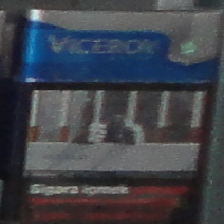

In [114]:
i=random.sample(range(len(train_ImageFileList)),1)[0]
image_viewer(train_ImageFileList[i], truncate=0, truncate_down=False)

In [115]:
nn_finder_c(i,1)[1]

'viceroy'

**Class Predictor Function_b**

Class Predictor Function Type B

In [0]:
def nn_finder_b(i,k):
  input_image = train_ImageFileList[i]
  test_feature = RD_maker_transfer_learned(input_image, truncate, truncate_down=True)
  test_feature = test_feature/RD_train_max
  
  test_feature[test_feature < class_int[0]] = 1
  test_feature[test_feature < class_int[1]] = 2
  test_feature[test_feature < class_int[2]] = 3
  test_feature[test_feature < class_int[3]] = 5
  test_feature[test_feature < class_int[4]] = 7

  RD_TEST = np.concatenate((RD_nn, test_feature), axis=1)
  BQRS_test = np.zeros((RD_nn.shape[1]+1, RD_nn.shape[1]+1))

  a = np.multiply(RD_TEST[:,-1].reshape([1001,-1]),RD_TEST)
  a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
  a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
  a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
  a[a==5] = wt[3]; a[a==14] = wt[3]
  a[a==7] = wt[4]
  
  new = a.sum(axis=0)
  new = new / new[-1]
  # BQRS_test[-1,0:] = a.sum(axis=0)
  # BQRS_test[0:,-1] = a.sum(axis=0)

  # BQRS_test[:RD_nn.shape[1],:RD_nn.shape[1]] = BQRS
  # BQRS_test = BQRS_test/np.diagonal(BQRS_test)
  # BQRS_test = BQRS_test.T
  # BQCorr1_test = np.zeros((RD_nn.shape[1]+1))
  # for j in range(RD_nn.shape[1]+1):
    # BQCorr1_test[j] = np.corrcoef(BQRS_test[-1], BQRS_test[j])[1,0]

  # predicts_image_top_k = np.array(train_labeled_files_flat)[BQRS_test[-1,0:].argsort()[-(k+1):][::-1][1:]]
  # predicts_class_top_k = np.array(train_labeled_class_flat)[BQRS_test[-1,0:].argsort()[-(k+1):][::-1][1:]]
  # top_BQRS_values = BQRS_test[-1,0:][BQRS_test[-1,0:].argsort()[-(k+1):][::-1][1:]]
  predicts_image_top_k = np.array(train_labeled_files_flat)[new.argsort()[-(k+1):][::-1][1:]]
  predicts_class_top_k = np.array(train_image_label)[new.argsort()[-(k+1):][::-1][1:]]
  top_BQRS_values = new[new.argsort()[-(k+1):][::-1][1:]]

  return input_image,predicts_class_top_k[0],predicts_class_top_k,top_BQRS_values,predicts_image_top_k

**Label checker on 30 randomly chosen images by running the predictor function on them**

Where 30 packs ordered row-wise starting with 0

In [0]:
def labeling_random_check():
  rndm = random.sample(range(len(train_ImageFileList)),30)
  nearest_neighbor_prediction=[]
  for i in notebook.tqdm(range(len(rndm))):
    nearest_neighbor_prediction.append([train_ImageFileList[rndm[i]],nn_finder_b(rndm[i],1)[1]])
  image_files = [nearest_neighbor_prediction[i][0] for i in range(len(rndm))]
  image_label = [nearest_neighbor_prediction[i][1] for i in range(len(rndm))]
  view_cluster_center(5,6, image_files, image_label, 10)
  return image_files

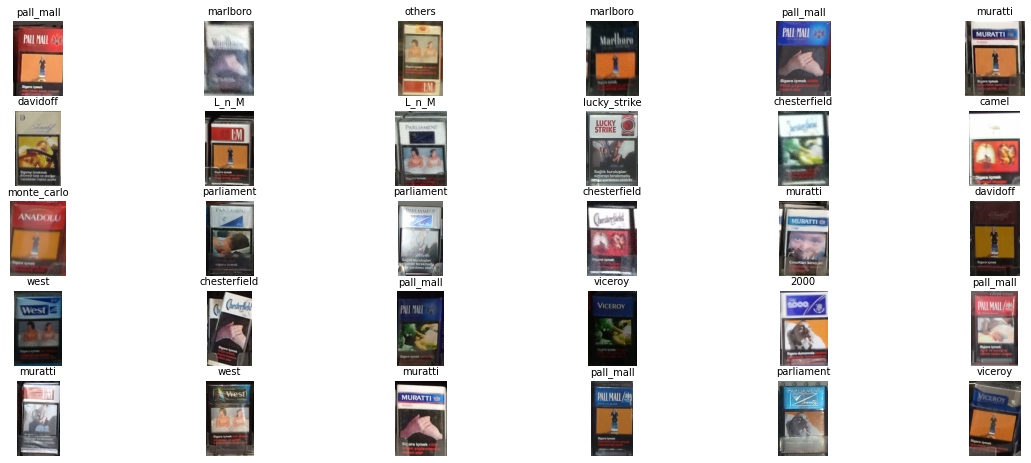

In [118]:
img = labeling_random_check()

**Mostly correct but there may be errors. Now run it across all 10440 images and predict their label.**

In [0]:
nearest_neighbor_prediction=[]
for i in notebook.tqdm(range(len(train_ImageFileList))):
  nearest_neighbor_prediction.append(nn_finder_b(i,5))

In [0]:
nearest_neighbor_prediction[0]

('/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2320_188_200_300.png',
 'marlboro',
 array(['marlboro', 'marlboro', 'marlboro', 'marlboro', 'marlboro'],
       dtype='<U16'),
 array([0.74581233, 0.74375788, 0.74113425, 0.73877215, 0.73815326]),
 array(['/content/drive/My Drive/ProductImagesFromShelves/0/C4_P07_N1_S3_2.JPG_2468_904_180_276.png',
        '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N1_S3_1.JPG_220_380_184_268.png',
        '/content/drive/My Drive/ProductImagesFromShelves/0/C1_P11_N1_S4_1.JPG_2912_828_240_348.png',
        '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P07_N2_S3_2.JPG_2512_320_176_300.png',
        '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P06_N1_S4_1.JPG_148_180_192_280.png'],
       dtype='<U91'))

**Pickle the total prediction file and send to google drive**

In [0]:
with open('/content/drive/My Drive/t/prediction.pkl', 'wb') as fp:
  pickle.dump(nearest_neighbor_prediction, fp)

**Unpickle prediction file from google drive and bring back**

In [0]:
with open('/content/drive/My Drive/t/prediction.pkl', "rb") as fp:
  nearest_neighbor_prediction = pickle.load(fp)

**Create a list of unlabeled image files, including 2340 labeled ones and their labels**

In [0]:
image_files = [nearest_neighbor_prediction[i][0] for i in range(len(train_ImageFileList))]
image_label = [nearest_neighbor_prediction[i][1] for i in range(len(train_ImageFileList))]

In [121]:
image_files[:5],image_label[:5]

(['/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2320_188_200_300.png',
  '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_1912_696_192_300.png',
  '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2268_1684_196_308.png',
  '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_2084_1680_196_308.png',
  '/content/drive/My Drive/ProductImagesFromShelves/0/C4_P05_N2_S4_1.JPG_1520_700_192_300.png'],
 ['marlboro', 'parliament', 'L_n_M', 'L_n_M', 'parliament'])

**Create Dataframe of image files and given labels**

In [0]:
# labeled_images_B = pd.DataFrame({'image_file_name': image_files, 'label_pred': image_label})

In [0]:
# labeled_images_B.head()

image_file_name  label_pred
0  /content/drive/My Drive/ProductImagesFromShelv...    marlboro
1  /content/drive/My Drive/ProductImagesFromShelv...  parliament
2  /content/drive/My Drive/ProductImagesFromShelv...       L_n_M
3  /content/drive/My Drive/ProductImagesFromShelv...       L_n_M
4  /content/drive/My Drive/ProductImagesFromShelv...  parliament

**Save the prediction dataframe to google drive**

In [0]:
# labeled_images_B.to_csv('/content/drive/My Drive/t/image_label_B.csv', sep=',', encoding='utf-8', index=False)

**Retrieve latest version of prediction dataframe `post manual corrections` from google drive**

In [0]:
labeled_images_B  = pd.read_csv('/content/drive/My Drive/t/image_label_B.csv', sep=',', encoding='utf-8')

**Function to check prediction accuracy for a given brand**

It is possible some brands will have higher accuracy than the others, so we could make necessary corrections

In [0]:
def random_label_checker(brand, label, sample):
  """
  Input:  List of labelled image files
          Label given based on Nearest Neighbor
          Number per sample (integer)
  Output: View of 10 randomly selected images from the list for verification
  """
  rndm = random.sample(range(len(brand)),sample)
  files = [brand[rndm[i]] for i in range(len(rndm))]
  label = [label]*sample
  view_cluster_center(int(sample/5), 5, files, label, 10)

**Function for random checking the predictions across brands using the dataframe to initiate correction of Label in case of errors**

In [0]:
def label_checker():
  """
  Output: View of 20 randomly selected images with predicted label for checking verification
  """
  rndm = random.sample(range(len(train_ImageFileList)),20)
  files = [labeled_images_B['image_file_name'].tolist()[rndm[i]] for i in range(len(rndm))]
  label = [labeled_images_B['label_pred'].tolist()[rndm[i]] for i in range(len(rndm))]
  view_cluster_center(4,5, files, label, 10)
  return rndm

**Function to reconfirm application of correction in the prediction dataframe**

In [0]:
def reconfirm_correction():
  """
  Output: View of 30 randomly selected images with predicted label for checking verification
  """
  files = [labeled_images_B['image_file_name'].tolist()[indx[i]] for i in range(len(indx))]
  label = [labeled_images_B['label_pred'].tolist()[indx[i]] for i in range(len(indx))]
  view_cluster_center(4,5, files, label, 10)  

**Check randomly selected 20 images from 10440 and correct label if needed**

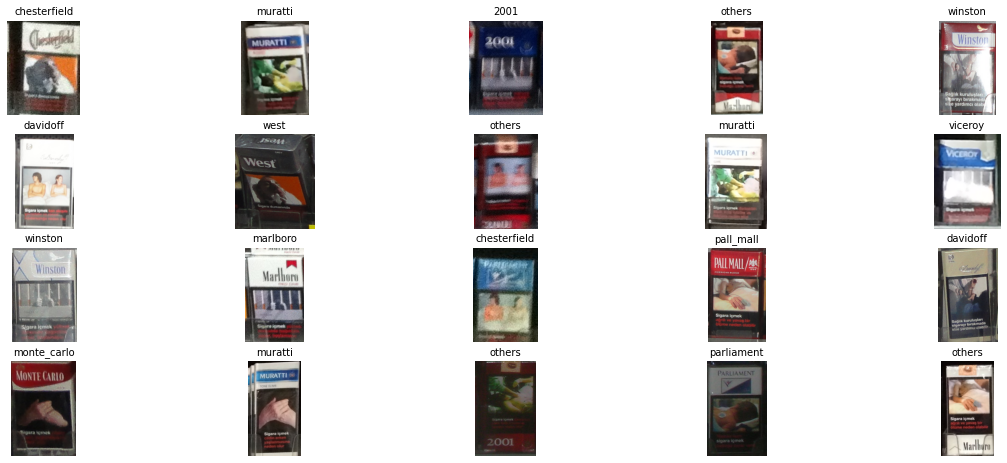

In [126]:
indx=label_checker()

**Make a Correction**

In [127]:
input_string = input("Enter a serial number of error pack followed by correct brand separated by space: ")
errorlist = input_string.split()

Enter a serial number of error pack followed by correct brand separated by space: 12 parliament


**Reconfirm label based on zoomed in image of the error pack**

Index of error:  4578 ,  current incorrect label:  chesterfield ,  Corrected label:  parliament


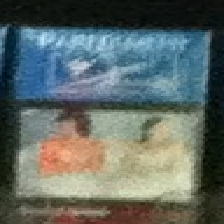

In [128]:
print('Index of error: ', indx[int(errorlist[0])],', ','current incorrect label: ', labeled_images_B['label_pred'].tolist()[indx[int(errorlist[0])]],', ', 'Corrected label: ', errorlist[1])
image_viewer(train_ImageFileList[indx[int(errorlist[0])]],truncate=0,truncate_down=False)

**Apply Correction**

In [0]:
labeled_images_B['label_pred'].iloc[[indx[int(errorlist[0])]]] = errorlist[1]

**Reconfirm correction at dataframe row**

In [130]:
labeled_images_B.iloc[[indx[int(errorlist[0])]]]

image_file_name  label_pred
4578  /content/drive/My Drive/ProductImagesFromShelv...  parliament

**Reconfirm correction at visually**

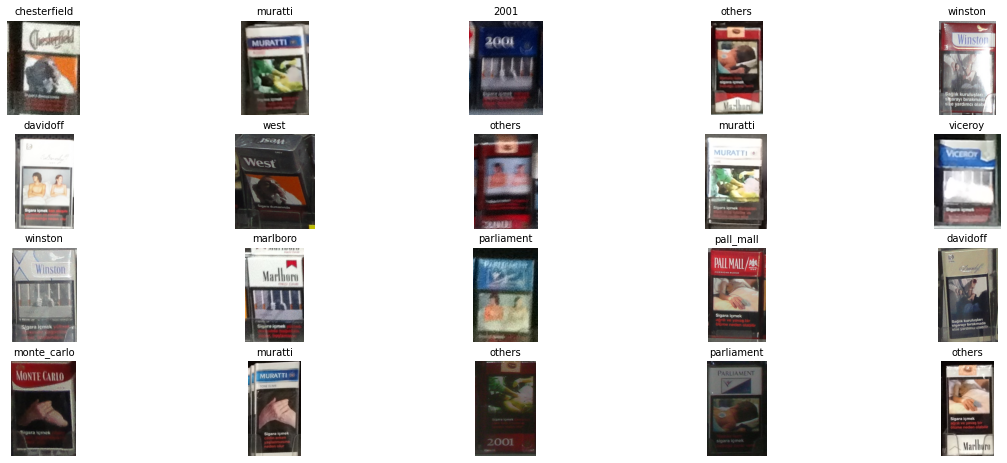

In [131]:
reconfirm_correction()

**Update the prediction dataframe**

In [0]:
labeled_images_B.to_csv('/content/drive/My Drive/t/image_label_B.csv', sep=',', encoding='utf-8', index=False)

#Estimating Numeric and Weighted Accuracy of predictions for 30 brands starting with brand 0 L_n_M
We draw 20 samples randomly for each brand and record number of errors out of 20. This we repeat 5 times for an overall sample size of 100. We estimate accuracy both as numeric and weighted by the number of images under each brand.

Total number of  polo packs:  57


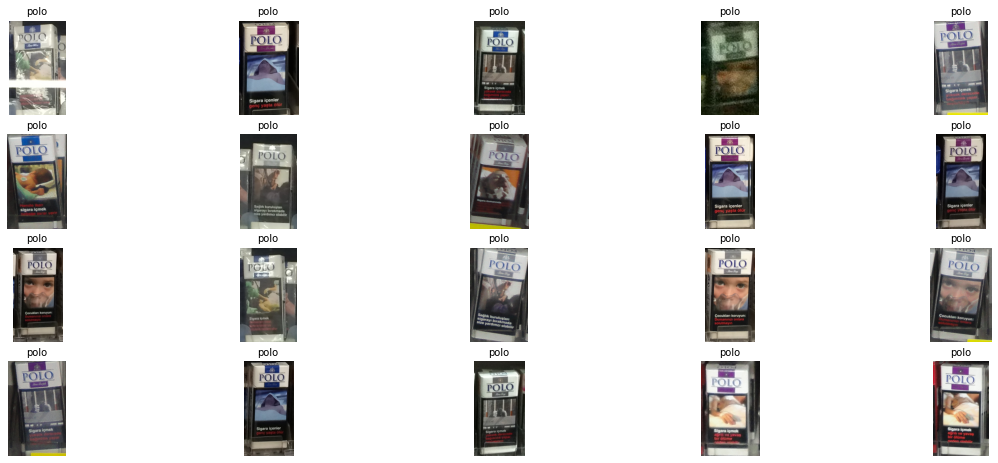

In [284]:
i=25
print('Total number of ', brand_list[i], 'packs: ', len(labeled_images_B.loc[labeled_images_B['label_pred'] == brand_list[i]].values[:,0]))
random_label_checker(labeled_images_B.loc[labeled_images_B['label_pred'] == brand_list[i]].values[:,0], brand_list[i], 20)

**Get number of images predicted under each brand totalling to 10440**

In [0]:
brand_base = [len(labeled_images_B.loc[labeled_images_B['label_pred'] == brand_list[i]].values[:,0]) for i in range(len(brand_list))]

**For accuracy calculation have used brands with at least 50 images**

8 brands have been excluded from labeling and classification accuracy calculation of the corpus 

In [0]:
num_err_0 = 3+3+4+2+4              # L&M
num_err_1 = 2+1+0+1+1              # Others
num_err_2 = 2+3+2+4+3              # Chesterfield
num_err_3 = 1+1+0+2+2              # Parliament
num_err_4 = 2+3+3+5+2              # Muratti
num_err_5 = 2+2+2+2+1              # Lark
num_err_6 = 0+1+1+1+1              # Bond
num_err_7 = 1+2+2+3+0              # Marlboro
num_err_8 = 3+1+2+3+4              # Kent
num_err_9 = 1+1+1+1+0              # Vogue
num_err_10= 3+3+0+4+3              # 2000
num_err_11= 1+2+0+2+2              # Pall Mall
num_err_12= 5+4+2+1+2              # 2001 | Samsun 216 and Maltepe are very few in number. Hence ignored
num_err_15= 1+1+1+0+0              # Lucky Strike
num_err_16= 1+2+2+0+3              # Winston
num_err_17= 4+3+2+1+2              # Camel
num_err_18= 0+1+0+1+1              # Monte Carlo
num_err_19= 1+3+3+0+3              # Viceroy
num_err_20= 8+3+5+3+1              # West
num_err_21= 2+3+1+0+3              # L*D | Glamour has too few packs. Ignored
num_err_23= 1+3+4+1+0              # Davidoff | Imperial Classic has too few packs. Hence ignored
num_err_25= 1+1+0+0+0              # Polo | Salem, Bianca, Anadolu, More have too few packs. Hence ignored

In [0]:
num_err=num_err_0+num_err_1+num_err_2+num_err_3+num_err_4+num_err_5+num_err_6+num_err_7+num_err_8+num_err_9+num_err_10+num_err_11+\
num_err_12+num_err_15+num_err_16+num_err_17+num_err_18+num_err_19+num_err_20+num_err_21+num_err_22+num_err_23+num_err_25
accuracy_unwtd=1 - num_err/(23*100)

accuracy_wtd = 1 - (num_err_0*brand_base[0]+num_err_1*brand_base[1]+num_err_2*brand_base[2]+num_err_3*brand_base[3]+num_err_4*brand_base[4]+\
num_err_5*brand_base[5]+num_err_6*brand_base[6]+num_err_7*brand_base[7]+num_err_8*brand_base[8]+num_err_9*brand_base[9]+\
num_err_10*brand_base[10]+num_err_11*brand_base[11]+num_err_12*brand_base[12]+num_err_15*brand_base[15]+num_err_16*brand_base[16]+\
num_err_17*brand_base[17]+num_err_18*brand_base[18]+num_err_19*brand_base[19]+num_err_20*brand_base[20]+num_err_21*brand_base[21]+\
num_err_23*brand_base[23]+num_err_25*brand_base[25])/((sum(brand_base)-brand_base[13]-brand_base[14]-brand_base[22]-brand_base[24]-\
                                                                                 brand_base[26]-brand_base[27]-brand_base[28]-brand_base[29])*100)

In [289]:
accuracy_unwtd, accuracy_wtd

(0.9008695652173913, 0.8962547584187408)

In [290]:
(accuracy_wtd*10440-2340)/(10440-2340)

0.8662839108508215

## The **overall labeling and classification accuracy now stands at 90%** of the unlabeled corpus of 10440 images. It has improved by 3% over the baseline due to a few rounds of error correction procedure applied above. It will reach 100% once all errors are corrected as shown.